# Predição do indíce da Ibovespa

Vamos criar um modelo preditivo que seja capaz de prever o o preço das ações do Ibovespa. Para isso, usaremos dados históricos, disponíveis no dataset abaixo. Este dataset contém os registros das ações desde o início até a data atual e contém informações úteis para predizermos o preço de fechamento e a variação.

Dataset disponível em: https://br.investing.com/indices/bovespa

### 1. Entendendo o dataset de entrada

In [52]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

Informações sobre os atributos:

- Data,
- Último,
- Abertura,
- Máxima,
- Mínima,
- Vol.,
- Var%

In [53]:
# Importação dos Dados - arquivo com dados da Ibovespa
dados = pd.read_csv("Dados Históricos - Ibovespa.csv")

In [54]:
# Linhas e colunas do dataset
dados.shape

(5000, 7)

In [55]:
# Informações sobre os dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Data      5000 non-null   object 
 1   Último    5000 non-null   float64
 2   Abertura  5000 non-null   float64
 3   Máxima    5000 non-null   float64
 4   Mínima    5000 non-null   float64
 5   Vol.      4999 non-null   object 
 6   Var%      5000 non-null   object 
dtypes: float64(4), object(3)
memory usage: 273.6+ KB


In [56]:
# 5 primeiras linhas do dataset
dados.head()

,Data,Último,Abertura,Máxima,Mínima,Vol.,Var%
0,20.03.2023,100.923,101.982,102.328,100.679,"10,90M","-1,04%"
1,17.03.2023,101.982,103.434,103.434,101.664,"17,56M","-1,40%"
2,16.03.2023,103.435,102.683,103.911,102.455,"14,39M","0,74%"
3,15.03.2023,102.675,102.930,103.048,100.692,"15,25M","-0,25%"
4,14.03.2023,102.932,103.121,104.153,102.482,"13,13M","-0,18%"


### 2. Ajustando os dados

In [57]:
# Limpar coluna "Vol."
dados["Vol."] = dados["Vol."].str.replace("K", "").str.replace("M", "").str.replace(",", ".").astype(float)

# Limpar coluna "Var%"
dados["Var%"] = dados["Var%"].str.replace("%", "").str.replace(",", ".").astype(float)

# Transformar coluna "Data" em datetime com formato 'DD.MM.YYYY'
dados["Data"] = pd.to_datetime(dados["Data"], format='%d.%m.%Y')

# Ordenar por "Data"
dados.sort_values(by="Data", inplace=True)

# Definir a coluna "Data" como índice
dados.set_index("Data", inplace=True)

# Redefinindo o index
dados = dados.reset_index()

dados["Último"] = dados["Último"].shift(-1)

# Calcular as médias móveis de 7, 21, 30 dias
# dados["MM7"] = dados["Var%"].rolling(window=7).mean()
# dados["MM21"] = dados["Último"].rolling(window=21).mean()
dados["MM60"] = dados["Vol."].rolling(window=30).mean()
dados["MM360"] = dados["Último"].rolling(window=360).mean()

# Remover linhas com valores ausentes
dados.dropna(inplace=True)

dados = dados.drop(columns=["Data"])

# Imprimir as primeiras linhas para verificar se os dados estão corretamente ordenados e indexados
dados.tail()

,Último,Abertura,Máxima,Mínima,Vol.,Var%,MM60,MM360
4994,102.932,103.608,103.907,102.255,12.99,-0.48,13.469000,108.980058
4995,102.675,103.121,104.153,102.482,13.13,-0.18,13.553000,108.958619
4996,103.435,102.930,103.048,100.692,15.25,-0.25,13.685667,108.939111
4997,101.982,102.683,103.911,102.455,14.39,0.74,13.735333,108.915283
4998,100.923,103.434,103.434,101.664,17.56,-1.40,13.726667,108.888444


### 3. Definindo os hiperparâmetro e separando "test" e "train"

In [7]:
# Definindo as features e as labels
features = dados[["Vol.", "MM60", "MM360"]].values
labels = dados["Último"].values

In [8]:
# Base de teste = 0.3 | Base de treino = 0.7
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state = 42)

In [9]:
len(x_train) # Treino

3227

In [10]:
len(x_test) # Teste

1383

In [11]:
scaler = MinMaxScaler()

scaler.fit(x_train)

MinMaxScaler()

In [12]:
x_train_scaled = scaler.transform(x_train)
x_test_scaled = scaler.transform(x_test)

### 4. Definindo os modelos

In [13]:
# Regressão Linear
model_lr = LinearRegression()
model_lr.fit(x_train_scaled, y_train)

# Regressão de arvore de decisão
model_dt = DecisionTreeRegressor()
model_dt.fit(x_train_scaled, y_train)

# Random Forest
model_rf = RandomForestRegressor(n_estimators=100, max_depth=3, min_samples_leaf=2, max_features=3, random_state=42)
model_rf.fit(x_train, y_train)

# Ridge Regression
model_rd = Ridge(alpha=1.0)
model_rd.fit(x_train_scaled, y_train)

# Gradient Boosting
model_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gb.fit(x_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [14]:
# Definindo as predições
pred_lr = model_lr.predict(x_test_scaled)
pred_dt = model_dt.predict(x_test_scaled)
pred_gb = model_gb.predict(x_test_scaled)
pred_rf = model_rf.predict(x_test)
pred_rd = model_rd.predict(x_test_scaled)

### 5. Avaliando os modelos

#### Ridge

In [15]:
mae_rd = mean_absolute_error(y_test, pred_rd)
mse_rd = mean_squared_error(y_test, pred_rd)
r2_rd = r2_score(y_test, pred_rd)

print("MAE: ", mae_rd)
print("MSE: ", mse_rd)
print("R2: ", round(r2_rd*100, 2))

MAE:  7.032174998186406
MSE:  80.6855507355428
R2:  87.99


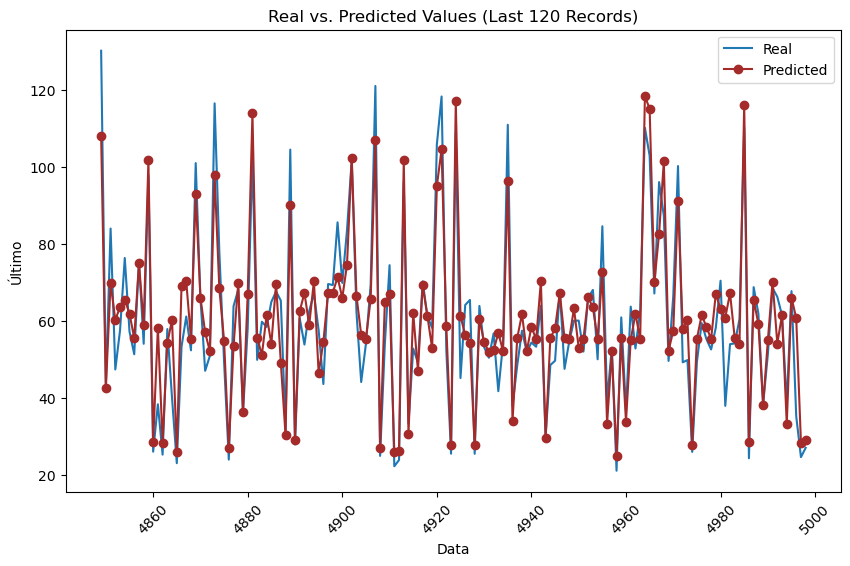

In [16]:
# Visualizar a diferença entre os valores reais e as previsões (últimos 120 registros)
plt.figure(figsize=(10, 6))
plt.plot(dados.index[-150:], y_test[-150:], label="Real", linestyle="-")
plt.plot(dados.index[-150:], pred_rd[-150:], label="Predicted", marker="o", color="brown")
plt.xlabel("Data")
plt.ylabel("Último")
plt.title("Real vs. Predicted Values (Last 120 Records)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Gradient Boosting

In [17]:
mae_gb = mean_absolute_error(y_test, pred_gb)
mse_gb = mean_squared_error(y_test, pred_gb)
r2_gb = r2_score(y_test, pred_gb)

print("MAE: ", mae_gb)
print("MSE: ", mse_gb)
print("R2: ", round(r2_gb*100, 2))

MAE:  3.9226022056992553
MSE:  30.72385209662002
R2:  95.43


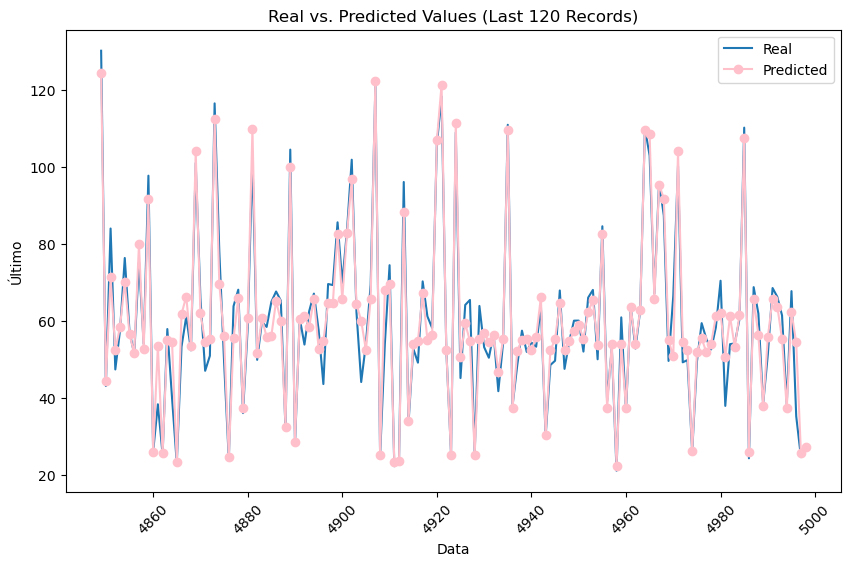

In [18]:
# Visualizar a diferença entre os valores reais e as previsões (últimos 120 registros)
plt.figure(figsize=(10, 6))
plt.plot(dados.index[-150:], y_test[-150:], label="Real", linestyle="-")
plt.plot(dados.index[-150:], pred_gb[-150:], label="Predicted", marker="o", color="pink")
plt.xlabel("Data")
plt.ylabel("Último")
plt.title("Real vs. Predicted Values (Last 120 Records)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Regressão Linear

In [19]:
mae_lr = mean_absolute_error(y_test, pred_lr)
mse_lr = mean_squared_error(y_test, pred_lr)
r2_lr = r2_score(y_test, pred_lr)

print("MAE: ", mae_lr)
print("MSE: ", mse_lr)
print("R2: ", round(r2_lr*100, 2))

MAE:  7.035888824662093
MSE:  80.74454543850169
R2:  87.98


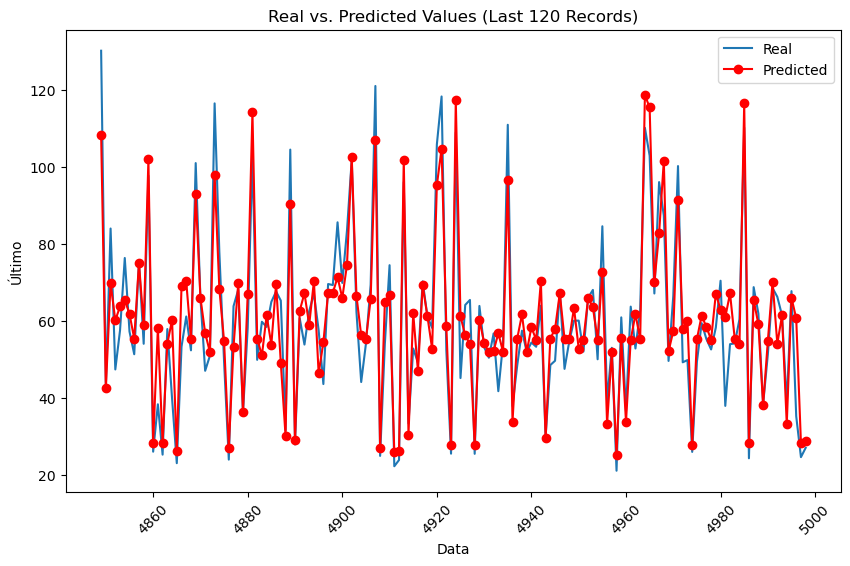

In [20]:
# Visualizar a diferença entre os valores reais e as previsões (últimos 120 registros)
plt.figure(figsize=(10, 6))
plt.plot(dados.index[-150:], y_test[-150:], label="Real", linestyle="-")
plt.plot(dados.index[-150:], pred_lr[-150:], label="Predicted", marker="o", color="red")
plt.xlabel("Data")
plt.ylabel("Último")
plt.title("Real vs. Predicted Values (Last 120 Records)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Arvore de Decisão

In [21]:
mae_dt = mean_absolute_error(y_test, pred_dt)
mse_dt = mean_squared_error(y_test, pred_dt)
r2_dt = r2_score(y_test, pred_dt)

print("MAE: ", mae_dt)
print("MSE: ", mse_dt)
print("R2: ", round(r2_dt*100, 2))

MAE:  1.8206384671005063
MSE:  19.32039911135213
R2:  97.12


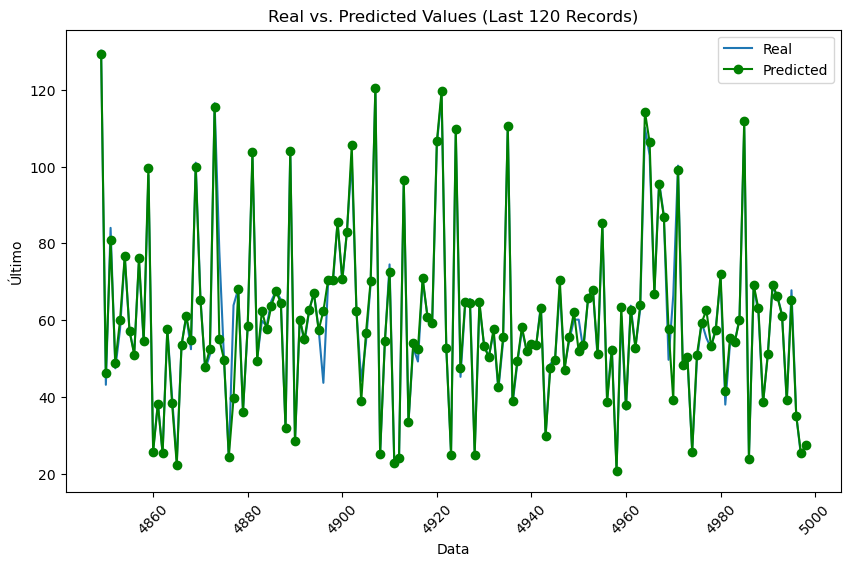

In [22]:
# Visualizar a diferença entre os valores reais e as previsões (últimos 120 registros)
plt.figure(figsize=(10, 6))
plt.plot(dados.index[-150:], y_test[-150:], label="Real", linestyle="-")
plt.plot(dados.index[-150:], pred_dt[-150:], label="Predicted", marker="o", color="green")
plt.xlabel("Data")
plt.ylabel("Último")
plt.title("Real vs. Predicted Values (Last 120 Records)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

#### Random Forest

In [23]:
mae_rf = mean_absolute_error(y_test, pred_rf)
mse_rf = mean_squared_error(y_test, pred_rf)
r2_rf = r2_score(y_test, pred_rf)

print("MAE: ", mae_rf)
print("MSE: ", mse_rf)
print("R2: ", round(r2_rf*100, 2))

MAE:  5.393004058694875
MSE:  51.69632434798019
R2:  92.31


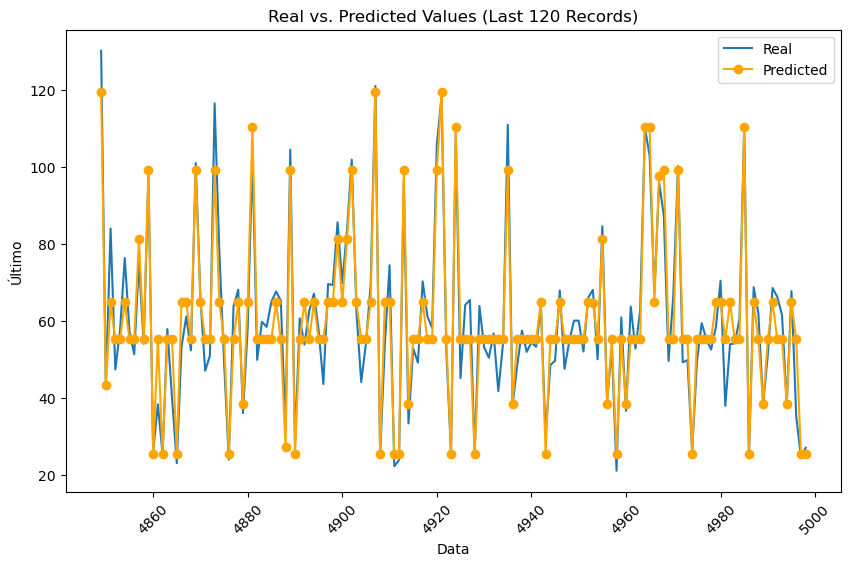

In [24]:
# Visualizar a diferença entre os valores reais e as previsões (últimos 120 registros)
plt.figure(figsize=(10, 6))
plt.plot(dados.index[-150:], y_test[-150:], label="Real", linestyle="-")
plt.plot(dados.index[-150:], pred_rf[-150:], label="Predicted", marker="o", color="orange")
plt.xlabel("Data")
plt.ylabel("Último")
plt.title("Real vs. Predicted Values (Last 120 Records)")
plt.legend()
plt.xticks(rotation=45)
plt.show()

### 6. Comparando os testes


**DecisionTreeRegressor**: Apresentou um R2 de aproximadamente 0.96, o que é alto, dando a entender que ele está bem ajustados aos dados, porém no contexto da previsão de preços de ações, altos níveis de precisão podem ser alcançados devido a padrões claros em séries temporais de preços.

**RegressionLinear**: Apresentou um R2 de aproximadamente 0.88, o que é um valor bastante razoável em comparação com o valor anterior, porém com um MSE de 81,47 e um MAE de 7,10 dificilmente este modelo poderá ser usado, porém ainda é uma solução plausível caso haja dúvidas de overfitting com o primeiro modelo, porém este modelo errou a tendência em alguns casos.

**RandomForest**: Apresentou um R2 de aproximadamente 0.92, que é um valor superior a regressão Linear, porém analisando visualmente os dados notamos que diferentemente da regressão linear em diversos momentos ele não segue a tendência e sim opta por um valor médio, contudo possui um MSE de 52.67 o que ainda é alto.

In [29]:
mae_list = [mae_dt, mae_lr, mae_rf, mae_gb, mae_rd]
mse_list = [mse_dt, mse_lr, mse_rf, mse_gb, mse_rd]
r2_lis = [r2_dt, r2_lr, r2_rf, r2_gb, r2_rd]
model_list = ["DecisionTree", "RegressionLinear", "RForest", "GB", "Ridge"]
cores = ["green", "red", "orange", "pink", "brown"]

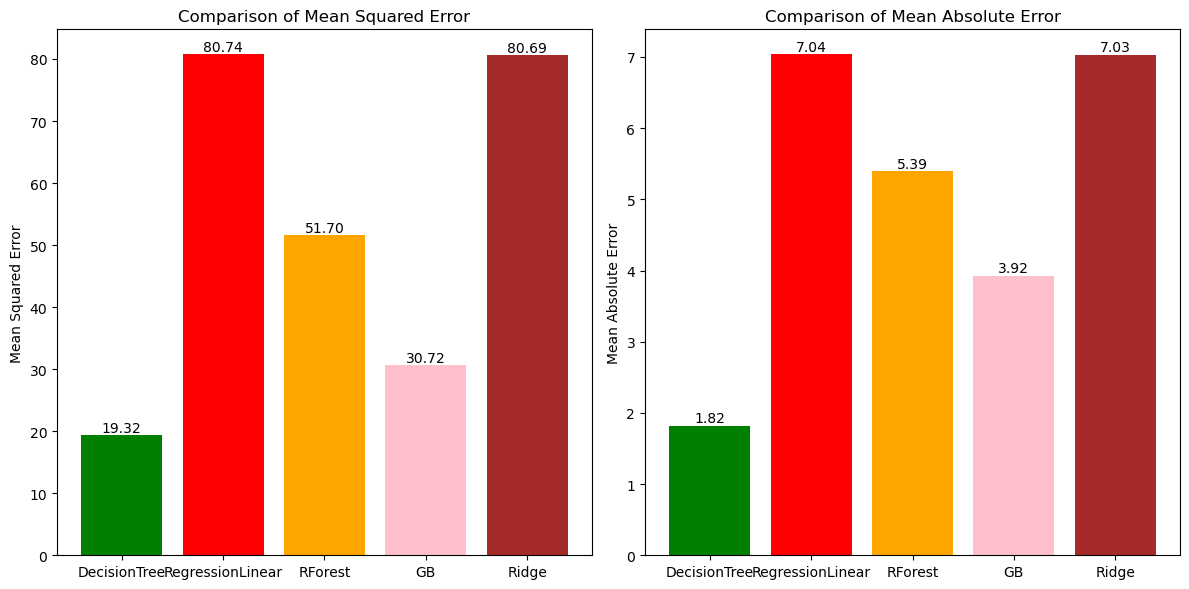

In [26]:
# Criar o gráfico com 2 subplots
plt.figure(figsize=(12, 6))

# Subplot 1 - MSE
plt.subplot(1, 2, 1)
bars_mse = plt.bar(model_list, mse_list, color=cores)
plt.ylabel('Mean Squared Error')
plt.title('Comparison of Mean Squared Error')

# Adicionar valores nas barras do Subplot 1
for bar, value in zip(bars_mse, mse_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Subplot 2 - MAE
plt.subplot(1, 2, 2)
bars_mae = plt.bar(model_list, mae_list, color=cores)
plt.ylabel('Mean Absolute Error')
plt.title('Comparison of Mean Absolute Error')

# Adicionar valores nas barras do Subplot 2
for bar, value in zip(bars_mae, mae_list):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.01, f'{value:.2f}', ha='center', va='bottom')

# Ajustar o layout
plt.tight_layout()

# Mostrar o gráfico
plt.show()

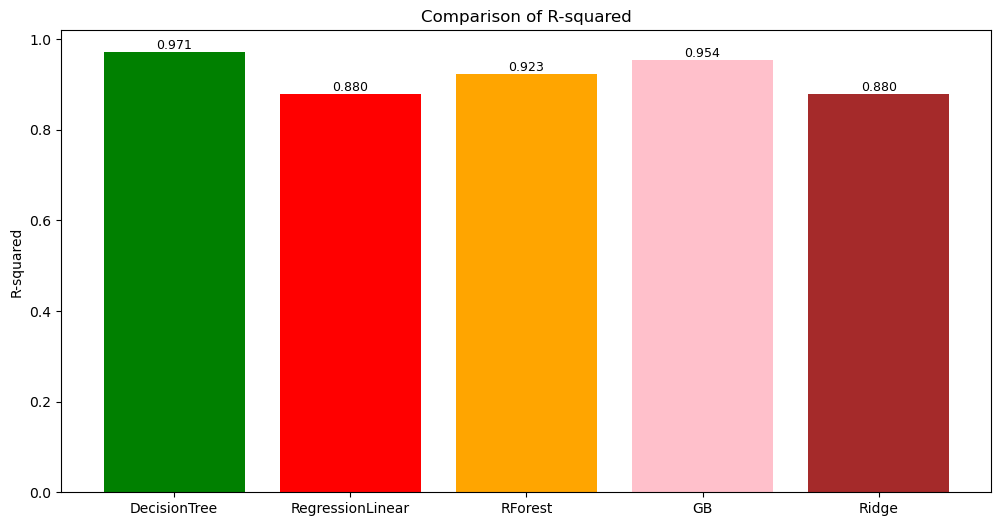

In [30]:
# Plot R-squared
plt.figure(figsize=(12, 6))
bars_r2 = plt.bar(model_list, r2_lis, color=cores)
plt.ylabel('R-squared')
plt.title('Comparison of R-squared')
# Adicionar os valores de R-squared acima das barras
for bar, value in zip(bars_r2, r2_lis):
    plt.text(bar.get_x() + bar.get_width() / 2, value, f'{value:.3f}', ha='center', va='bottom', color='black', fontsize=9)

### 7. Exportando os modelos treinados

Após este passos os modelos ficam disponíveis como um arquivo ".pkl" e pode ser utlizado posteriormente fora deste projeto.

In [68]:
import joblib

# Salvar os modelos usando joblib
joblib.dump(model_lr, 'models/LinearRegressionModel.pkl')
joblib.dump(model_dt, 'models/DecisionTreeModel.pkl')
joblib.dump(model_gb, 'models/GradientBoostingModel.pkl')
joblib.dump(model_dt, 'models/RandomForestModel.pkl')
joblib.dump(model_rd, 'models/RidgeModel.pkl')

# Para carregar os modelos posteriormente
# modelo_lr = joblib.load('modelo_lr.pkl')
# modelo_dt = joblib.load('modelo_dt.pkl')
# modelo_gb = joblib.load('modelo_gb.pkl')
# modelo_rf = joblib.load('modelo_rf.pkl')
# modelo_rd = joblib.load('modelo_rd.pkl')

['models/RidgeModel.pkl']